### time-mean dQ2 target vs RF/NN-ens prediction maps 

In [1]:
import fv3viz
import xarray as xr
import fsspec
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Mapping
import os
import string
from vcm.catalog import catalog as CATALOG
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
from cartopy import crs as ccrs

In [2]:
@dataclass
class MLOfflineDiags:
    name: str
    root: str
    model_variables: Mapping[str, Sequence[str]]
        
@dataclass
class Variable:
    name: str
    long_name: str
    units: str

In [3]:
dQ1 = Variable('column_integrated_dQ1', 'column-integrated heating (dQ1)', 'W/m^2')
dQ2 = Variable('column_integrated_dQ2', 'column-integrated moistening (dQ2)', 'mm/day')
dQu = Variable('column_integrated_dQu', 'column-integrated easterly wind tendency (dQu)', 'Pa')
dQv = Variable('column_integrated_dQv', 'column-integrated northerly wind tendency (dQv)', 'Pa')
downward_shortwave = Variable('override_for_time_adjusted_total_sky_downward_shortwave_flux_at_surface', 'downward shortwave', 'W/m^2')
downward_longwave = Variable('override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface', 'downward longwave', 'W/m^2')
net_shortwave = Variable('override_for_time_adjusted_total_sky_net_shortwave_flux_at_surface', 'net shortwave', 'W/m^2')

RUNS = [
    MLOfflineDiags(
        '$TqR$-RF',
        'gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/offline_diags',
        {
            'postphysics_ML_tendencies': [dQ1, dQ2],
            'prephysics_ML_surface_flux': [downward_shortwave, downward_longwave, net_shortwave]
        }
    ),
    MLOfflineDiags(
        '$TqR$-NN',
         'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags',
        {
            'dq1-dq2': [dQ1, dQ2],
            'dqu-dqv': [dQu, dQv],
            'surface-rad-rectified': [downward_shortwave, downward_longwave, net_shortwave]
        }
    )       
]

OUTDIR = 'figures'

In [4]:
def open_diags(path):
    with fsspec.open(path, 'rb') as f:
        ds = xr.open_dataset(f).load()
    return ds

pred_datasets = []
target_ds = {}
for run in RUNS:
    run_pred_ds = {}
    for model in run.model_variables.keys():
        path = os.path.join(run.root, model, 'offline_diagnostics.nc')
        print(path)
        diags = open_diags(path)
        for variable in run.model_variables[model]:
            if variable.name not in target_ds:
                target_ds[variable.name] = (
                    diags[variable.name]
                    .sel(derivation='target')
                    .drop_vars('derivation')
                ).assign_attrs({
                'long_name': variable.long_name,
                'units': variable.units
            })
            run_pred_ds[variable.name + '_bias'] = (
                diags[variable.name]
                .sel(derivation='predict')
                .drop_vars('derivation') - target_ds[variable.name]
            ).assign_attrs({
                'long_name': variable.long_name,
                'units': variable.units
            })
            run_pred_ds[variable.name] = (
                diags[variable.name]
                .sel(derivation='predict')
                .drop_vars('derivation')
            ).assign_attrs({
                'long_name': variable.long_name,
                'units': variable.units
            })
    for variable in [dQu, dQv]:
        if variable.name not in run_pred_ds:
            run_pred_ds[variable.name] = xr.full_like(run_pred_ds['column_integrated_dQ1'], np.nan)
            run_pred_ds[variable.name + '_bias'] = xr.full_like(run_pred_ds['column_integrated_dQ1'], np.nan)
    pred_datasets.append(xr.Dataset(run_pred_ds).expand_dims({'derivation': [run.name]}))
pred_ds = xr.concat(pred_datasets, dim='derivation')
target_ds = xr.Dataset(target_ds).expand_dims({'derivation': ['target']})

gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/offline_diags/postphysics_ML_tendencies/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/offline_diags/prephysics_ML_surface_flux/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dq1-dq2/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dqu-dqv/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/surface-rad-rectified/offline_diagnostics.nc


In [5]:
ds = xr.merge([pred_ds, target_ds]).reindex({'derivation': ['target', '$TqR$-RF', '$TqR$-NN']})

In [6]:
def weighted_mean(ds, weights):
    return ((ds*weights).sum(dim=['x', 'y', 'tile']))/(weights.sum(dim=['x', 'y', 'tile']))

def weighted_rms(ds, weights):
    return np.sqrt(
        (((ds**2)*weights).sum(dim=['x', 'y', 'tile']))/(weights.sum(dim=['x', 'y', 'tile']))
    )

In [7]:
grid = CATALOG['grid/c48'].to_dask()
MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

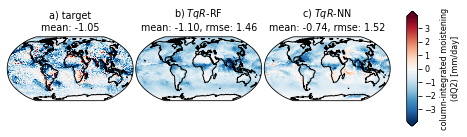

In [8]:
var = 'column_integrated_dQ2'
means = weighted_mean(ds[var], grid['area'])
rmses = weighted_rms(ds[var + '_bias'], grid['area'])
_, _, _, cbar, fg = fv3viz.plot_cube(
    fv3viz.mappable_var(xr.merge([grid, ds]), var, **MAPPABLE_VAR_KWARGS),
    col = 'derivation'
)
for i, (ax, case, mean, rmse) in enumerate(zip(fg.axes.flatten(), ds.derivation.values, means.values, rmses.values)):
    if case != 'target':
        ax.set_title(f"{string.ascii_lowercase[i]}) {case}\nmean: {mean:.2f}, rmse: {rmse:.2f}")
    else:
        ax.set_title(f"{string.ascii_lowercase[i]}) {case}\nmean: {mean:.2f}")
cbar.set_ticks(np.linspace(-3, 3, 7))
fg.fig.set_size_inches([7.6, 2])
fg.fig.savefig(f'{OUTDIR}/Figure_5_column_integrated_dQ2_offline_time_mean.eps', bbox_inches='tight', dpi=150)

In [9]:
def add_total_downward(ds):
    total_downward_bias = (
        ds['override_for_time_adjusted_total_sky_downward_shortwave_flux_at_surface_bias'] + ds['override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface_bias']
    ).assign_attrs({'long_name': 'total downwelling surface radiation bias', 'units': 'W/m^2'})
    ds['downward_total_radiative_flux_at_surface_bias'] = total_downward_bias
    return ds

ds = add_total_downward(ds)

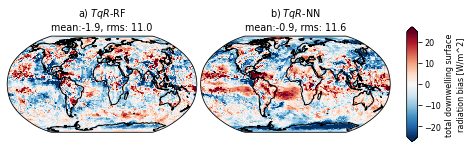

In [10]:
var = 'downward_total_radiative_flux_at_surface_bias'
ds_pred = ds.sel({'derivation': ['$TqR$-RF', '$TqR$-NN']})
means = weighted_mean(ds_pred[var], grid['area'])
rmss = weighted_rms(ds_pred[var], grid['area'])

_, _, _, _, fg = fv3viz.plot_cube(
    fv3viz.mappable_var(xr.merge([grid, ds_pred]), var, **MAPPABLE_VAR_KWARGS),
    col = 'derivation'
)
for i, (ax, case, mean, rms) in enumerate(zip(fg.axes.flatten(), ds_pred.derivation.values, means.values, rmss.values)):
    ax.set_title(f"{string.ascii_lowercase[i]}) {case}\nmean:{mean:.1f}, rms: {rms:0.1f}")
fg.fig.set_size_inches([7.6, 2])
fg.fig.savefig(
    f'{OUTDIR}/Figure_A3_downward_total_radiative_flux_at_surface_bias_offline_time_mean.eps',
    bbox_inches='tight'
)

In [11]:
# this converts matplotlib eps files to a more manageable size

!epstopdf figures/Figure_5_column_integrated_dQ2_offline_time_mean.eps
!pdftops -eps figures/Figure_5_column_integrated_dQ2_offline_time_mean.pdf
!rm figures/Figure_5_column_integrated_dQ2_offline_time_mean.pdf

!epstopdf figures/Figure_A3_downward_total_radiative_flux_at_surface_bias_offline_time_mean.eps
!pdftops -eps figures/Figure_A3_downward_total_radiative_flux_at_surface_bias_offline_time_mean.pdf
!rm figures/Figure_A3_downward_total_radiative_flux_at_surface_bias_offline_time_mean.pdf